# Omid Was Here


Importing CelebAMask-HQ data set from my google drive to colab.
This data set is massive and have 3.1 G size so it take time.
Models, Loss function, Optimizer and transformations are in the folder of faceparsing and shod be uploaded in zip file before starting.


In [ ]:
!unzip '/content/drive/My Drive/Colab Notebooks/Dataset/CelebADataset/CelebAMask-HQPre.zip'
!unzip faceparsing.zip
!pip install face_alignment


Logger: is logging class \
loss: OhemLoss class\
model: Bisenet model => not used in my case\
Models: consist of resnet18, resnet18plus which is my proposed model and resnet with attention model.\
optimizer: consist of SGD optimizer with all hyper parameters\
face_dataset: is used for data augmentation and transformation for trainig and testing perpose.\
transform: necessery functions and classes for making face_dataset tranformation reality :)


In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# import os
# os.chdir('/content/gdrive/My Drive/Colab Notebooks/Dataset/CelebADataset')


In [2]:
#Most common packages 
import os.path as osp
import os
import cv2
import numpy as np
from PIL import Image
import logging
import time
import datetime
import argparse
import pandas as pd
import glob
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# This part is for FAN network to predict face keypoints using heatmap and
# compare with my result
import face_alignment
from skimage import io

# importing pytorch libraries

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.distributed as dist
import matplotlib.pyplot as plt
import torchvision
from torch.autograd import Variable
import torchvision.transforms as transforms
import torch.utils.model_zoo as modelzoo
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.distributed as dist

#Set cuda Driver 
use_cuda = torch.cuda.is_available()
device = torch.device('cuda:0' if use_cuda else 'cpu')

#My Models nad classes
from faceparsing.face_dataset import FaceMask
from faceparsing.transform import *

from faceparsing.Models import Resnet18Plus,ResidualAttentionModel_448input
from faceparsing.Models import ResidualAttentionModel_448input as net
from faceparsing.logger import setup_logger
from faceparsing.loss import OhemCELoss
from faceparsing.optimizer import Optimizer

# Setting log path 
respth = './logMyData'
if not osp.exists(respth):
    os.makedirs(respth)
    os.makedirs(respth+'/cp')
logger = logging.getLogger()




# Preprocessing
This will convert our dataset labels to one file with multi mask instead of multi label files

In [ ]:
#Pre Process Data once No Need Anymore


face_data = 'CelebAMask-HQ/CelebA-HQ-img'
face_sep_mask = 'CelebAMask-HQ/CelebAMask-HQ-mask-anno'
mask_path = 'CelebAMask-HQ/mask'
counter = 0
total = 0
for i in range(15):

    atts = ['skin', 'l_brow', 'r_brow', 'l_eye', 'r_eye', 'eye_g', 'l_ear', 'r_ear', 'ear_r',
            'nose', 'mouth', 'u_lip', 'l_lip', 'neck', 'neck_l', 'cloth', 'hair', 'hat']

    for j in range(i * 2000, (i + 1) * 2000):

        mask = np.zeros((512, 512))

        for l, att in enumerate(atts, 1):
            total += 1
            file_name = ''.join([str(j).rjust(5, '0'), '_', att, '.png'])
            path = osp.join(face_sep_mask, str(i), file_name)

            if os.path.exists(path):
                counter += 1
                sep_mask = np.array(Image.open(path).convert('P'))
                # print(np.unique(sep_mask))

                mask[sep_mask == 225] = l
        cv2.imwrite('{}/{}.png'.format(mask_path, j), mask)
        print(j)

print(counter, total)

In the case of the trained network this will load the weights
Resnet18Plus is our model which has been trained for more than 4000 iteration.



In [3]:
#Loading Net
!cp '/content/drive/My Drive/Colab Notebooks/Dataset/CelebADataset/6999_iter.pth' '/content/logMyData/cp' 
net = Resnet18Plus()

net.load_state_dict(torch.load('logMyData/cp/6999_iter.pth'))

<All keys matched successfully>

This part is for loading  resnet with attention model and load the weights

In [3]:
# net = Resnet18Plus()
!cp '/content/drive/My Drive/Colab Notebooks/Dataset/CelebADataset/netB_4000_iter.pth' '/content/logMyData/cp' 

torch.cuda.set_device(device)
net = net()
net.load_state_dict(torch.load('logMyData/cp/netB_4000_iter.pth'))

a,b = net.get_params()

In this part we will run distrbuted data loader for training perpose( no need any more First I wanted to train on multi GPU)
set all parameters and load dataset into dataloader


In [4]:
  torch.cuda.set_device(device)
  dist.init_process_group(
                backend = 'nccl',
                init_method = 'tcp://127.0.0.1:33241',
                world_size = torch.cuda.device_count(),
                rank=0
                )
  setup_logger(respth)
  # dataset
  n_classes = 19
  n_img_per_gpu = 16
  n_workers = 8
  cropsize = [448, 448]
  data_root = 'CelebAMask-HQ/'
  score_thres = 0.7
  n_min = n_img_per_gpu * cropsize[0] * cropsize[1]//16

  #Loading dataset 

  ds = FaceMask(data_root, cropsize=cropsize, mode='train')
  sampler = torch.utils.data.distributed.DistributedSampler(ds)
  dl = DataLoader(ds,
                    batch_size = n_img_per_gpu,
                    shuffle = False,
                    sampler = sampler,
                    num_workers = n_workers,
                    pin_memory = True,
                    drop_last = True)

  # For Validation Dataset
  # This will return Images without transformation which should be used for testing 
  # perpose

  ds_test = FaceMask(data_root, cropsize=cropsize, mode='test')
  dTest = DataLoader(ds_test,
                    batch_size = 16,
                    shuffle = True,
                    num_workers = n_workers,
                    pin_memory = True,
                    drop_last = True)
  
  # model set to use cuda
  ignore_idx = -100
  net.cuda()
  net.float()
  


ResidualAttentionModel_448input(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (mpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (residual_block0): ResidualBlock(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias

In [5]:
def NewTrainV2(dl,net):
  # args = parse_args()
  
  net.train()
  # net = nn.parallel.DistributedDataParallel(net,
  #           find_unused_parameters = False,
  #           device_ids = [device, ],
  #           output_device = device )
  score_thres = 0.7
  n_min = n_img_per_gpu * cropsize[0] * cropsize[1]//16
  LossP = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
  Loss2 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
  Loss3 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)

  ## optimizer
  msg_iter = 100
  max_iter = 4000
  momentum = 0.9
  weight_decay = 5e-4
  lr_start = 1e-2
  power = 0.9
  warmup_steps = 100
  warmup_start_lr = 1e-3
  optim = Optimizer(
            model = net,
            lr0 = lr_start,
            momentum = momentum,
            wd = weight_decay,
            warmup_steps = warmup_steps,
            warmup_start_lr = warmup_start_lr,
            max_iter = max_iter,
            power = power)
  


  # criterion = nn.CrossEntropyLoss(ignore_index=-100, reduction='none')
  # criterion = criterion.to(device)
  # optimizer = optim.Adam(net.parameters(),lr=0.001,weight_decay=1,betas=(0.9,0.999))
  training_loss = []

  
  loss_avg = []
  st = glob_st = time.time()
  diter = iter(dl)
  epoch = 0
  
  for it in range(max_iter):
        try:
            print('In TRY OK.')
            im, lb = next(diter)
            if not im.size()[0] == n_img_per_gpu:
                raise StopIteration
        except StopIteration:
            print('In except OK.')
            epoch += 1
            sampler.set_epoch(epoch)
            diter = iter(dl)
            im, lb = next(diter)
        im = im.to(device)
        lb = lb.to(device)
        print('Read Data at iter ')
        H, W = im.size()[2:]
        lb = torch.squeeze(lb, 1)
        optim.zero_grad()
        
        # pred1,pred2 = net(im)
        out, out16, out32 = net(im)

        # print('after pred',pred1.size(),pred2.size())
        # loss1 = criterion(out, lb)
        # loss1 = torch.mean(loss1)
        # loss2 = criterion(out16, lb)
        # loss2 = torch.mean(loss2)
        # loss3 = criterion(out32, lb)
        # loss3 = torch.mean(loss3)
        # loss = loss1+loss2+loss3
        # loss2 = criterion(pred2, pts2)
        # loss3 = criterion(pred2, pts2)
        lossp = LossP(out, lb)
        loss2 = Loss2(out16, lb)
        loss3 = Loss3(out32, lb)
        loss = lossp + loss2 + loss3
        loss.backward()
        optim.step()

        # loss.backward()

        # optimizer.step()
        print('optim calculated OK. + ')
        print(it)
        # print(loss1.size())

        loss_avg.append(loss.item())
        # wandb.log({"Images" : wandb.Image(im)})

        #  print training log message
        if (it+1) % msg_iter == 0:
            print('enter IF OK.')
            loss_avg = sum(loss_avg) / len(loss_avg)
            # lr = optimizer.lr
            ed = time.time()

            t_intv, glob_t_intv = ed - st, ed - glob_st
            eta = int((max_iter - it) * (glob_t_intv / it))
            eta = str(datetime.timedelta(seconds=eta))
            print('Hello iter {}'.format(it))
            msg = ', '.join([
                    'it: {it}/{max_it}',
                    'loss: {loss:.4f}',
                    'eta: {eta}',
                    'time: {time:.4f}',
                ]).format(
                    it = it+1,
                    max_it = max_iter,
                    loss = loss_avg,
                    time = t_intv,
                    eta = eta,
                )
            logger.info(msg)
            loss_avg = []
            st = ed
        if dist.get_rank() == 0:
            if (it+1) % 500 == 0:
                state = net.module.state_dict() if hasattr(net, 'module') else net.state_dict()
                if dist.get_rank() == 0:
                    torch.save(state, 'logMyData/cp/{}_iter.pth'.format(it))
                # evaluate(dspth='/home/zll/data/CelebAMask-HQ/test-img', cp='{}_iter.pth'.format(it))

    #  dump the final model
  save_pth = osp.join(respth, 'model_final_diss.pth')
    # net.cpu()
  state = net.module.state_dict() if hasattr(net, 'module') else net.state_dict()
  if dist.get_rank() == 0:
      torch.save(state, save_pth)
  logger.info('training done, model saved to: {}'.format(save_pth))
  return net

  # LossP = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
  # Loss2 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
  # Loss3 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)

  # # define the data tranform
  # data_transform = transforms.Compose([
  #                                      Rescale(600),
  #                                      RandomCrop(512),
  #                                      ToTensor(),
  #                                      Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
  #                                      ])
  # ds = FacialKeypointsDatasetModiffied(Data_rootTrain,data_CSVTrain, cropsize=cropsize, mode='train',data_transform)
  # sampler = torch.utils.data.distributed.DistributedSampler(ds)
  # dl = DataLoader(ds,
  #                   batch_size = n_img_per_gpu,
  #                   shuffle = False,
  #                   sampler = sampler,
  #                   num_workers = n_workers,
  #                   pin_memory = True,
  #                   drop_last = True)

def test(net,optim,LossP,Loss2,Loss3,imTest,lbTest):

  with torch.no_grad():
    im = imTest.to(device)
    lb = lbTest.to(device)
    out, out16, out32 = net(im)
    lossp = LossP(out, lb)
    loss2 = Loss2(out16, lb)
    loss3 = Loss3(out32, lb)
    loss = lossp + loss2 + loss3
    loss_avg = []
    loss_avg.append(lossTest.item())
    loss_avg = sum(loss_avg) / len(loss_avg)

  return loss_avg


  


# Training function

In [5]:
def NewTrainV3(dl,net):

  # Init loss class 
  
  net.train()
  score_thres = 0.7
  n_min = n_img_per_gpu * cropsize[0] * cropsize[1]//16
  LossP = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
  Loss2 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
  Loss3 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)

  ## optimizer
  msg_iter = 50
  max_iter = 300
  momentum = 0.9
  weight_decay = 5e-4
  lr_start = 1e-2
  power = 0.9
  warmup_steps = 100
  warmup_start_lr = 1e-3
  optim = Optimizer(
            model = net,
            lr0 = lr_start,
            momentum = momentum,
            wd = weight_decay,
            warmup_steps = warmup_steps,
            warmup_start_lr = warmup_start_lr,
            max_iter = max_iter,
            power = power)
  

  # preparing data to be trained
  training_loss = []

  
  loss_avg = []
  st = glob_st = time.time()
  diter = iter(dl)
  diterTest = iter(dTest)
  imTest,lbTest = next(diterTest)
  epoch = 0

  # Iteration loop start from here
  # if data loader finished all data once it will increase the number of epoch 
  # by one and continue. so we just set the total number of iterations
  
  for it in range(max_iter):
        try:
            print('In TRY OK.')
            im, lb = next(diter)
            if not im.size()[0] == n_img_per_gpu:
                raise StopIteration
        except StopIteration:
            print('In except OK.')
            epoch += 1
            sampler.set_epoch(epoch)
            diter = iter(dl)
            im, lb = next(diter)
            im, lb = next(diter)

        # loading batch of images and labels

        im = im.to(device)
        lb = lb.to(device)
        print('Read Data at iter ')
        H, W = im.size()[2:]
        lb = torch.squeeze(lb, 1)
        optim.zero_grad()
        
        # predicting result
        out, out16, out32 = net(im)

        # calculating loss
        lossp = LossP(out, lb)
        loss2 = Loss2(out16, lb)
        loss3 = Loss3(out32, lb)
        loss = lossp + loss2 + loss3
        # optimize
        loss.backward()
        optim.step()

        print('optim calculated OK. + ')
        print(it)

        loss_avg.append(loss.item())
        # wandb.log({"Images" : wandb.Image(im)})

        #  print training log message
        if (it+1) % msg_iter == 0:
            print('enter IF OK.')
            loss_avg = sum(loss_avg) / len(loss_avg)
            lr = optim.lr
            ed = time.time()
            Val = test(net,optim,LossP,Loss2,Loss3,imTest,lbTest)

            t_intv, glob_t_intv = ed - st, ed - glob_st
            eta = int((max_iter - it) * (glob_t_intv / it))
            eta = str(datetime.timedelta(seconds=eta))
            print('Hello iter {}'.format(it))
            msg = ', '.join([
                    'it: {it}/{max_it}',
                    'loss: {loss:.4f}',
                    'eta: {eta}',
                    'time: {time:.4f}',
                    'lr: {lr}',
                    'Val: {Val:.4f}'
                ]).format(
                    it = it+1,
                    max_it = max_iter,
                    loss = loss_avg,
                    time = t_intv,
                    eta = eta,
                    lr = lr,
                    Val = Val
                )
            logger.info(msg)
            loss_avg = []
            st = ed
        if dist.get_rank() == 0:
            if (it+1) % 500 == 0:
                state = net.module.state_dict() if hasattr(net, 'module') else net.state_dict()
                if dist.get_rank() == 0:
                    torch.save(state, 'logMyData/cp/{}_iter.pth'.format(it))

    #  dump the final model
  save_pth = osp.join(respth, 'model_final_diss.pth')
    # net.cpu()
  state = net.module.state_dict() if hasattr(net, 'module') else net.state_dict()
  if dist.get_rank() == 0:
      torch.save(state, save_pth)
  logger.info('training done, model saved to: {}'.format(save_pth))
  return net

# for testing the result of the network after certain iterations
# 
def test(net,optim,LossP,Loss2,Loss3,imTest,lbTest):

  with torch.no_grad():
    netT = net
    im = imTest.to(device)
    lb = lbTest.to(device)
    lb = torch.squeeze(lb, 1)
    print(im.size(),lb.size())
    out, out16, out32 = netT(im)
    print('done net')
    lossp = LossP(out, lb)
    loss2 = Loss2(out16, lb)
    loss3 = Loss3(out32, lb)
    loss = lossp + loss2 + loss3
    print('done loss')
    loss_avg = []
    loss_avg.append(loss.item())
    loss_avg = sum(loss_avg) / len(loss_avg)
    del im,lb,netT
    
  return loss_avg
  


This is the result of the Resnet18Plus which is my model.
We trainde for only 300 it because we have trained network for 4000 it before

In [8]:
NewTrainV3(dl,net)


In TRY OK.
Read Data at iter 
optim calculated OK. + 
0
In TRY OK.
Read Data at iter 
optim calculated OK. + 
1
In TRY OK.
Read Data at iter 
optim calculated OK. + 
2
In TRY OK.
Read Data at iter 
optim calculated OK. + 
3
In TRY OK.
Read Data at iter 
optim calculated OK. + 
4
In TRY OK.
Read Data at iter 
optim calculated OK. + 
5
In TRY OK.
Read Data at iter 
optim calculated OK. + 
6
In TRY OK.
Read Data at iter 
optim calculated OK. + 
7
In TRY OK.
Read Data at iter 
optim calculated OK. + 
8
In TRY OK.
Read Data at iter 
optim calculated OK. + 
9
In TRY OK.
Read Data at iter 
optim calculated OK. + 
10
In TRY OK.
Read Data at iter 
optim calculated OK. + 
11
In TRY OK.
Read Data at iter 
optim calculated OK. + 
12
In TRY OK.
Read Data at iter 
optim calculated OK. + 
13
In TRY OK.
Read Data at iter 
optim calculated OK. + 
14
In TRY OK.
Read Data at iter 
optim calculated OK. + 
15
In TRY OK.
Read Data at iter 
optim calculated OK. + 
16
In TRY OK.
Read Data at iter 
optim calcu

it: 50/300, loss: 2.8345, eta: 0:04:08, time: 48.4826, lr: 0.0030902954325135856, Val: 2.6996


enter IF OK.
torch.Size([16, 3, 448, 448]) torch.Size([16, 448, 448])
done net
done loss
Hello iter 49
In TRY OK.
Read Data at iter 
optim calculated OK. + 
50
In TRY OK.
Read Data at iter 
optim calculated OK. + 
51
In TRY OK.
Read Data at iter 
optim calculated OK. + 
52
In TRY OK.
Read Data at iter 
optim calculated OK. + 
53
In TRY OK.
Read Data at iter 
optim calculated OK. + 
54
In TRY OK.
Read Data at iter 
optim calculated OK. + 
55
In TRY OK.
Read Data at iter 
optim calculated OK. + 
56
In TRY OK.
Read Data at iter 
optim calculated OK. + 
57
In TRY OK.
Read Data at iter 
optim calculated OK. + 
58
In TRY OK.
Read Data at iter 
optim calculated OK. + 
59
In TRY OK.
Read Data at iter 
optim calculated OK. + 
60
In TRY OK.
Read Data at iter 
optim calculated OK. + 
61
In TRY OK.
Read Data at iter 
optim calculated OK. + 
62
In TRY OK.
Read Data at iter 
optim calculated OK. + 
63
In TRY OK.
Read Data at iter 
optim calculated OK. + 
64
In TRY OK.
Read Data at iter 
optim calcul

it: 100/300, loss: 3.0112, eta: 0:02:44, time: 32.6204, lr: 0.009772372209558077, Val: 2.8782


enter IF OK.
torch.Size([16, 3, 448, 448]) torch.Size([16, 448, 448])
done net
done loss
Hello iter 99
In TRY OK.
Read Data at iter 
optim calculated OK. + 
100
In TRY OK.
Read Data at iter 


==> warmup done, start to implement poly lr strategy


optim calculated OK. + 
101
In TRY OK.
Read Data at iter 
optim calculated OK. + 
102
In TRY OK.
Read Data at iter 
optim calculated OK. + 
103
In TRY OK.
Read Data at iter 
optim calculated OK. + 
104
In TRY OK.
Read Data at iter 
optim calculated OK. + 
105
In TRY OK.
Read Data at iter 
optim calculated OK. + 
106
In TRY OK.
Read Data at iter 
optim calculated OK. + 
107
In TRY OK.
Read Data at iter 
optim calculated OK. + 
108
In TRY OK.
Read Data at iter 
optim calculated OK. + 
109
In TRY OK.
Read Data at iter 
optim calculated OK. + 
110
In TRY OK.
Read Data at iter 
optim calculated OK. + 
111
In TRY OK.
Read Data at iter 
optim calculated OK. + 
112
In TRY OK.
Read Data at iter 
optim calculated OK. + 
113
In TRY OK.
Read Data at iter 
optim calculated OK. + 
114
In TRY OK.
Read Data at iter 
optim calculated OK. + 
115
In TRY OK.
Read Data at iter 
optim calculated OK. + 
116
In TRY OK.
Read Data at iter 
optim calculated OK. + 
117
In TRY OK.
Read Data at iter 
optim calculat

it: 150/300, loss: 3.0636, eta: 0:01:56, time: 33.3706, lr: 0.007765193037454269, Val: 2.9939


done loss
Hello iter 149
In TRY OK.
Read Data at iter 
optim calculated OK. + 
150
In TRY OK.
Read Data at iter 
optim calculated OK. + 
151
In TRY OK.
Read Data at iter 
optim calculated OK. + 
152
In TRY OK.
Read Data at iter 
optim calculated OK. + 
153
In TRY OK.
Read Data at iter 
optim calculated OK. + 
154
In TRY OK.
Read Data at iter 
optim calculated OK. + 
155
In TRY OK.
Read Data at iter 
optim calculated OK. + 
156
In TRY OK.
Read Data at iter 
optim calculated OK. + 
157
In TRY OK.
Read Data at iter 
optim calculated OK. + 
158
In TRY OK.
Read Data at iter 
optim calculated OK. + 
159
In TRY OK.
Read Data at iter 
optim calculated OK. + 
160
In TRY OK.
Read Data at iter 
optim calculated OK. + 
161
In TRY OK.
Read Data at iter 
optim calculated OK. + 
162
In TRY OK.
Read Data at iter 
optim calculated OK. + 
163
In TRY OK.
Read Data at iter 
optim calculated OK. + 
164
In TRY OK.
Read Data at iter 
optim calculated OK. + 
165
In TRY OK.
Read Data at iter 
optim calculated 

it: 200/300, loss: 2.9588, eta: 0:01:15, time: 33.3730, lr: 0.005407073091552649, Val: 2.7347


enter IF OK.
torch.Size([16, 3, 448, 448]) torch.Size([16, 448, 448])
done net
done loss
Hello iter 199
In TRY OK.
Read Data at iter 
optim calculated OK. + 
200
In TRY OK.
Read Data at iter 
optim calculated OK. + 
201
In TRY OK.
Read Data at iter 
optim calculated OK. + 
202
In TRY OK.
Read Data at iter 
optim calculated OK. + 
203
In TRY OK.
Read Data at iter 
optim calculated OK. + 
204
In TRY OK.
Read Data at iter 
optim calculated OK. + 
205
In TRY OK.
Read Data at iter 
optim calculated OK. + 
206
In TRY OK.
Read Data at iter 
optim calculated OK. + 
207
In TRY OK.
Read Data at iter 
optim calculated OK. + 
208
In TRY OK.
Read Data at iter 
optim calculated OK. + 
209
In TRY OK.
Read Data at iter 
optim calculated OK. + 
210
In TRY OK.
Read Data at iter 
optim calculated OK. + 
211
In TRY OK.
Read Data at iter 
optim calculated OK. + 
212
In TRY OK.
Read Data at iter 
optim calculated OK. + 
213
In TRY OK.
Read Data at iter 
optim calculated OK. + 
214
In TRY OK.
Read Data at it

it: 250/300, loss: 2.9639, eta: 0:00:37, time: 33.2256, lr: 0.0029233859971803866, Val: 2.6871


done loss
Hello iter 249
In TRY OK.
Read Data at iter 
optim calculated OK. + 
250
In TRY OK.
Read Data at iter 
optim calculated OK. + 
251
In TRY OK.
Read Data at iter 
optim calculated OK. + 
252
In TRY OK.
Read Data at iter 
optim calculated OK. + 
253
In TRY OK.
Read Data at iter 
optim calculated OK. + 
254
In TRY OK.
Read Data at iter 
optim calculated OK. + 
255
In TRY OK.
Read Data at iter 
optim calculated OK. + 
256
In TRY OK.
Read Data at iter 
optim calculated OK. + 
257
In TRY OK.
Read Data at iter 
optim calculated OK. + 
258
In TRY OK.
Read Data at iter 
optim calculated OK. + 
259
In TRY OK.
Read Data at iter 
optim calculated OK. + 
260
In TRY OK.
Read Data at iter 
optim calculated OK. + 
261
In TRY OK.
Read Data at iter 
optim calculated OK. + 
262
In TRY OK.
Read Data at iter 
optim calculated OK. + 
263
In TRY OK.
Read Data at iter 
optim calculated OK. + 
264
In TRY OK.
Read Data at iter 
optim calculated OK. + 
265
In TRY OK.
Read Data at iter 
optim calculated 

it: 300/300, loss: 2.8735, eta: 0:00:00, time: 33.1234, lr: 8.493232323171241e-05, Val: 2.7316


enter IF OK.
torch.Size([16, 3, 448, 448]) torch.Size([16, 448, 448])
done net
done loss
Hello iter 299


training done, model saved to: ./logMyData/model_final_diss.pth


Resnet18Plus(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(

This is the result of the resnet with attention which is test model.
We trained for only 300 it because we have trained network for 4000 it before

In [6]:
NewTrainV3(dl,net)


In TRY OK.
Read Data at iter 
optim calculated OK. + 
0
In TRY OK.
Read Data at iter 
optim calculated OK. + 
1
In TRY OK.
Read Data at iter 
optim calculated OK. + 
2
In TRY OK.
Read Data at iter 
optim calculated OK. + 
3
In TRY OK.
Read Data at iter 
optim calculated OK. + 
4
In TRY OK.
Read Data at iter 
optim calculated OK. + 
5
In TRY OK.
Read Data at iter 
optim calculated OK. + 
6
In TRY OK.
Read Data at iter 
optim calculated OK. + 
7
In TRY OK.
Read Data at iter 
optim calculated OK. + 
8
In TRY OK.
Read Data at iter 
optim calculated OK. + 
9
In TRY OK.
Read Data at iter 
optim calculated OK. + 
10
In TRY OK.
Read Data at iter 
optim calculated OK. + 
11
In TRY OK.
Read Data at iter 
optim calculated OK. + 
12
In TRY OK.
Read Data at iter 
optim calculated OK. + 
13
In TRY OK.
Read Data at iter 
optim calculated OK. + 
14
In TRY OK.
Read Data at iter 
optim calculated OK. + 
15
In TRY OK.
Read Data at iter 
optim calculated OK. + 
16
In TRY OK.
Read Data at iter 
optim calcu

it: 50/300, loss: 3.2761, eta: 0:05:53, time: 69.0249, lr: 0.0030902954325135856, Val: 3.4273


done loss
Hello iter 49
In TRY OK.
Read Data at iter 
optim calculated OK. + 
50
In TRY OK.
Read Data at iter 
optim calculated OK. + 
51
In TRY OK.
Read Data at iter 
optim calculated OK. + 
52
In TRY OK.
Read Data at iter 
optim calculated OK. + 
53
In TRY OK.
Read Data at iter 
optim calculated OK. + 
54
In TRY OK.
Read Data at iter 
optim calculated OK. + 
55
In TRY OK.
Read Data at iter 
optim calculated OK. + 
56
In TRY OK.
Read Data at iter 
optim calculated OK. + 
57
In TRY OK.
Read Data at iter 
optim calculated OK. + 
58
In TRY OK.
Read Data at iter 
optim calculated OK. + 
59
In TRY OK.
Read Data at iter 
optim calculated OK. + 
60
In TRY OK.
Read Data at iter 
optim calculated OK. + 
61
In TRY OK.
Read Data at iter 
optim calculated OK. + 
62
In TRY OK.
Read Data at iter 
optim calculated OK. + 
63
In TRY OK.
Read Data at iter 
optim calculated OK. + 
64
In TRY OK.
Read Data at iter 
optim calculated OK. + 
65
In TRY OK.
Read Data at iter 
optim calculated OK. + 
66
In TRY 

it: 100/300, loss: 3.3730, eta: 0:04:04, time: 51.4631, lr: 0.009772372209558077, Val: 3.5354


done loss
Hello iter 99
In TRY OK.
Read Data at iter 
optim calculated OK. + 
100
In TRY OK.
Read Data at iter 


==> warmup done, start to implement poly lr strategy


optim calculated OK. + 
101
In TRY OK.
Read Data at iter 
optim calculated OK. + 
102
In TRY OK.
Read Data at iter 
optim calculated OK. + 
103
In TRY OK.
Read Data at iter 
optim calculated OK. + 
104
In TRY OK.
Read Data at iter 
optim calculated OK. + 
105
In TRY OK.
Read Data at iter 
optim calculated OK. + 
106
In TRY OK.
Read Data at iter 
optim calculated OK. + 
107
In TRY OK.
Read Data at iter 
optim calculated OK. + 
108
In TRY OK.
Read Data at iter 
optim calculated OK. + 
109
In TRY OK.
Read Data at iter 
optim calculated OK. + 
110
In TRY OK.
Read Data at iter 
optim calculated OK. + 
111
In TRY OK.
Read Data at iter 
optim calculated OK. + 
112
In TRY OK.
Read Data at iter 
optim calculated OK. + 
113
In TRY OK.
Read Data at iter 
optim calculated OK. + 
114
In TRY OK.
Read Data at iter 
optim calculated OK. + 
115
In TRY OK.
Read Data at iter 
optim calculated OK. + 
116
In TRY OK.
Read Data at iter 
optim calculated OK. + 
117
In TRY OK.
Read Data at iter 
optim calculat

it: 150/300, loss: 3.5257, eta: 0:02:54, time: 51.4530, lr: 0.007765193037454269, Val: 3.5095


done loss
Hello iter 149
In TRY OK.
Read Data at iter 
optim calculated OK. + 
150
In TRY OK.
Read Data at iter 
optim calculated OK. + 
151
In TRY OK.
Read Data at iter 
optim calculated OK. + 
152
In TRY OK.
Read Data at iter 
optim calculated OK. + 
153
In TRY OK.
Read Data at iter 
optim calculated OK. + 
154
In TRY OK.
Read Data at iter 
optim calculated OK. + 
155
In TRY OK.
Read Data at iter 
optim calculated OK. + 
156
In TRY OK.
Read Data at iter 
optim calculated OK. + 
157
In TRY OK.
Read Data at iter 
optim calculated OK. + 
158
In TRY OK.
Read Data at iter 
optim calculated OK. + 
159
In TRY OK.
Read Data at iter 
optim calculated OK. + 
160
In TRY OK.
Read Data at iter 
optim calculated OK. + 
161
In TRY OK.
Read Data at iter 
optim calculated OK. + 
162
In TRY OK.
Read Data at iter 
optim calculated OK. + 
163
In TRY OK.
Read Data at iter 
optim calculated OK. + 
164
In TRY OK.
Read Data at iter 
optim calculated OK. + 
165
In TRY OK.
Read Data at iter 
optim calculated 

it: 200/300, loss: 3.3484, eta: 0:01:53, time: 51.2899, lr: 0.005407073091552649, Val: 3.5278


done loss
Hello iter 199
In TRY OK.
Read Data at iter 
optim calculated OK. + 
200
In TRY OK.
Read Data at iter 
optim calculated OK. + 
201
In TRY OK.
Read Data at iter 
optim calculated OK. + 
202
In TRY OK.
Read Data at iter 
optim calculated OK. + 
203
In TRY OK.
Read Data at iter 
optim calculated OK. + 
204
In TRY OK.
Read Data at iter 
optim calculated OK. + 
205
In TRY OK.
Read Data at iter 
optim calculated OK. + 
206
In TRY OK.
Read Data at iter 
optim calculated OK. + 
207
In TRY OK.
Read Data at iter 
optim calculated OK. + 
208
In TRY OK.
Read Data at iter 
optim calculated OK. + 
209
In TRY OK.
Read Data at iter 
optim calculated OK. + 
210
In TRY OK.
Read Data at iter 
optim calculated OK. + 
211
In TRY OK.
Read Data at iter 
optim calculated OK. + 
212
In TRY OK.
Read Data at iter 
optim calculated OK. + 
213
In TRY OK.
Read Data at iter 
optim calculated OK. + 
214
In TRY OK.
Read Data at iter 
optim calculated OK. + 
215
In TRY OK.
Read Data at iter 
optim calculated 

it: 250/300, loss: 3.3728, eta: 0:00:56, time: 51.6484, lr: 0.0029233859971803866, Val: 3.3979


done loss
Hello iter 249
In TRY OK.
Read Data at iter 
optim calculated OK. + 
250
In TRY OK.
Read Data at iter 
optim calculated OK. + 
251
In TRY OK.
Read Data at iter 
optim calculated OK. + 
252
In TRY OK.
Read Data at iter 
optim calculated OK. + 
253
In TRY OK.
Read Data at iter 
optim calculated OK. + 
254
In TRY OK.
Read Data at iter 
optim calculated OK. + 
255
In TRY OK.
Read Data at iter 
optim calculated OK. + 
256
In TRY OK.
Read Data at iter 
optim calculated OK. + 
257
In TRY OK.
Read Data at iter 
optim calculated OK. + 
258
In TRY OK.
Read Data at iter 
optim calculated OK. + 
259
In TRY OK.
Read Data at iter 
optim calculated OK. + 
260
In TRY OK.
Read Data at iter 
optim calculated OK. + 
261
In TRY OK.
Read Data at iter 
optim calculated OK. + 
262
In TRY OK.
Read Data at iter 
optim calculated OK. + 
263
In TRY OK.
Read Data at iter 
optim calculated OK. + 
264
In TRY OK.
Read Data at iter 
optim calculated OK. + 
265
In TRY OK.
Read Data at iter 
optim calculated 

it: 300/300, loss: 3.2490, eta: 0:00:01, time: 51.5122, lr: 8.493232323171241e-05, Val: 3.1974


done loss
Hello iter 299


training done, model saved to: ./logMyData/model_final_diss.pth


ResidualAttentionModel_448input(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (mpool1): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (residual_block0): ResidualBlock(
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv1): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (conv4): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias

In [ ]:
# !cp '/content/logMyData/cp/999_iter.pth' '/content/drive/My Drive/Colab Notebooks/Dataset/CelebADataset/netB_1000_iter.pth'

In [7]:
# loading data set for exploring the result
i = iter(dTest)


In [8]:
im, lb = next(i)
im = im.cuda()
lb = lb.cuda()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 448, 448])


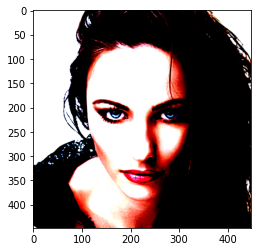

In [9]:
plt.imshow(im[7,:,:448,:448].cpu().numpy().transpose(1,2,0))
print(im[7,:,:448,:448].size())

This cell will show our features which has been extracted from the network\
As an example you can see how nose has been predicted on diffrent layer of resnet\


(448, 448)


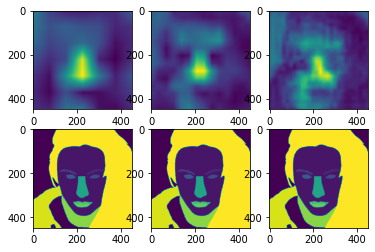

In [10]:

with torch.no_grad():

  a,b,c = net(im[:,:,:448,:448])
  parsing = a[7].squeeze(0).cpu().numpy().argmax(0)
  # print(parsing)
  # loss1 = criterion(a, lb)
  # print(loss1[6])

  # a = F.interpolate(a, [448,448], mode='bilinear')
  # b = F.interpolate(b, [448,448], mode='bilinear')
  aa = a[7].cpu().numpy().transpose(1,2,0)
  bb = b[7].cpu().numpy().transpose(1,2,0)
  cc = c[7].cpu().numpy().transpose(1,2,0)
  aa = aa[:,:,10]
  bb = bb[:,:,10]
  cc = cc[:,:,10]
  print(cc.shape)
  plt.subplot(2,3,1)
  plt.imshow(aa)
  plt.subplot(2,3,2)
  plt.imshow(bb)
  plt.subplot(2,3,3)
  plt.imshow(cc)
  plt.subplot(2,3,4)
  plt.imshow(lb[7].cpu().numpy().transpose(1,2,0).reshape(448,448))
  plt.subplot(2,3,5)
  plt.imshow(lb[7].cpu().numpy().transpose(1,2,0).reshape(448,448))
  plt.subplot(2,3,6)
  plt.imshow(lb[7].cpu().numpy().transpose(1,2,0).reshape(448,448))



This is 3d demonstration of predicted feature. as you can see values in z axis are much more than other values in nose erea.

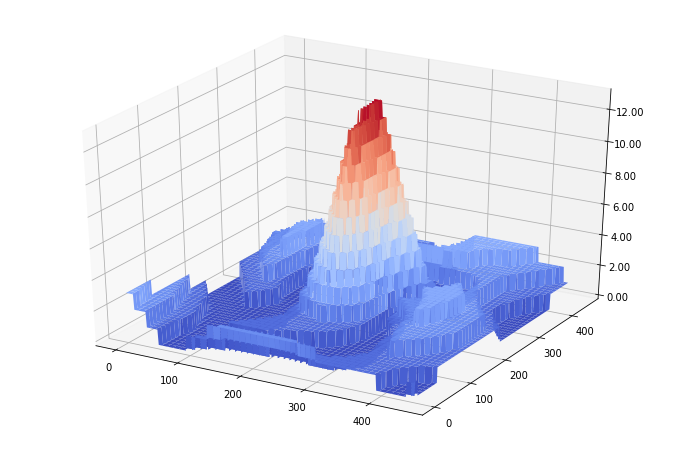

In [15]:
# xy,yx = np.meshgrid(x,y)
# z = np.sin(xy**2 + yx**2) / (xy**2 + yx**2)
# h = plt.contourf(x,y,z)
# plt.show()
temp3 = a+b+c
xx = np.linspace(0,448,448)
yy = np.linspace(0,448,448) 
X, Y = np.meshgrid(xx, yy)
zz = np.abs(temp3[7,10])
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
# ax.zaxis.set_major_locator(LinearLocator(2))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
ax.plot_surface(X,Y,zz, cmap=cm.coolwarm,linewidth=0, antialiased=True)

# xx1 = np.linspace(0,448,448)
# yy1 = np.linspace(0,448,448) 
# X1, Y1 = np.meshgrid(xx1, yy1)
# ax.plot_surface(X1, Y1, np.atleast_2d(2.0), rstride=1, cstride=1, facecolors=z1)
# plt.show()



# Testing results
This function will return all keypoints and also compare it in the picture with FAN method to predicting some face keypoints

array([[ 58,   0,   0],
       [363,   0,   0],
       [ 58,   1,   0],
       ...,
       [ 80, 319,  17],
       [ 81, 319,  17],
       [ 82, 319,  17]])

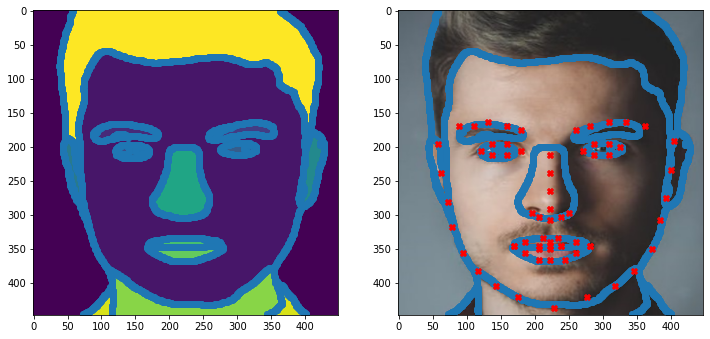

In [25]:
def test(network,path):
  fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
  
  timg = Image.open(path)
  timg = timg.resize((448, 448), Image.BILINEAR)
  timg = np.array(timg)
  img = timg
  timg = timg.transpose(2,0,1)
  timg = timg[np.newaxis,:,:,:]
  timg = torch.from_numpy(timg.astype(np.float)).type(torch.FloatTensor)
  timg = timg.to(device)
  pred = net(timg)
  pred = pred[0] + pred[1]+ pred[2]
  pred = pred[0]
  parsing = pred.squeeze(0).cpu().detach().numpy().argmax(0)

  # get landmarks by fan network
  FANpreds = fa.get_landmarks(img)
  FANpreds= np.array(FANpreds).reshape(68,2)

  x = np.linspace(0,447,448)
  y = np.linspace(0,447,448)
  # xx, yy = np.meshgrid(x, y)
  # zz = parsing
  cls = np.unique(parsing)
  points = []
  for i in cls:
    temp2 = np.zeros((448,448))
    x,y = np.where(parsing == i)
    temp2[x,y] = 255
    edges = cv2.Canny(np.uint8(temp2),448,448)
    x,y = np.where(edges == 255)
    for jj in range(len(x)):
      points.append([y[jj],x[jj],i])

  points = np.array(points)
  plt.figure(figsize=(12,12))
  plt.subplot(1,2,1)
  plt.imshow(parsing)
  plt.scatter(points[:,0],points[:,1])
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.scatter(points[:,0],points[:,1])
  plt.scatter(FANpreds[:,0],FANpreds[:,1],c='r',marker='X')


  return points

  # plt.figure(figsize=(12,8))
  # plt.imshow(parsing==1)
test(net,'imface.jpg')

Testing for another picture with resnet18plus network .

array([[225,   0,   0],
       [265,   0,   0],
       [266,   0,   0],
       ...,
       [169, 446,  17],
       [ 77, 447,  17],
       [168, 447,  17]])

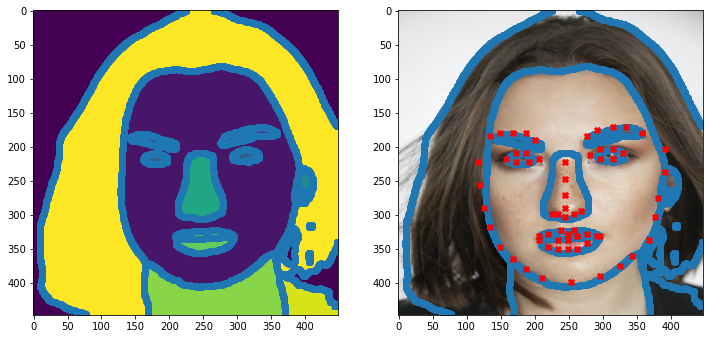

In [26]:
def test(network,path):
  fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
  
  timg = Image.open(path)
  timg = timg.resize((448, 448), Image.BILINEAR)
  timg = np.array(timg)
  img = timg
  timg = timg.transpose(2,0,1)
  timg = timg[np.newaxis,:,:,:]
  timg = torch.from_numpy(timg.astype(np.float)).type(torch.FloatTensor)
  timg = timg.to(device)
  pred = net(timg)
  pred = pred[0] + pred[1]+ pred[2]
  pred = pred[0]
  parsing = pred.squeeze(0).cpu().detach().numpy().argmax(0)

  FANpreds = fa.get_landmarks(img)
  FANpreds= np.array(FANpreds).reshape(68,2)

  x = np.linspace(0,447,448)
  y = np.linspace(0,447,448)
  # xx, yy = np.meshgrid(x, y)
  # zz = parsing
  cls = np.unique(parsing)
  points = []
  for i in cls:
    temp2 = np.zeros((448,448))
    x,y = np.where(parsing == i)
    temp2[x,y] = 255
    edges = cv2.Canny(np.uint8(temp2),448,448)
    x,y = np.where(edges == 255)
    for jj in range(len(x)):
      points.append([y[jj],x[jj],i])

  points = np.array(points)
  plt.figure(figsize=(12,12))
  plt.subplot(1,2,1)
  plt.imshow(parsing)
  plt.scatter(points[:,0],points[:,1])
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.scatter(points[:,0],points[:,1])
  plt.scatter(FANpreds[:,0],FANpreds[:,1],c='r',marker='X')


  return points

  # plt.figure(figsize=(12,8))
  # plt.imshow(parsing==1)
test(net,'face3.jpg')

Testing resnet with attention for the same picture to compare result with our network

array([[ 56,   0,   0],
       [390,   0,   0],
       [ 56,   1,   0],
       ...,
       [377, 446,  17],
       [350, 447,  17],
       [378, 447,  17]])

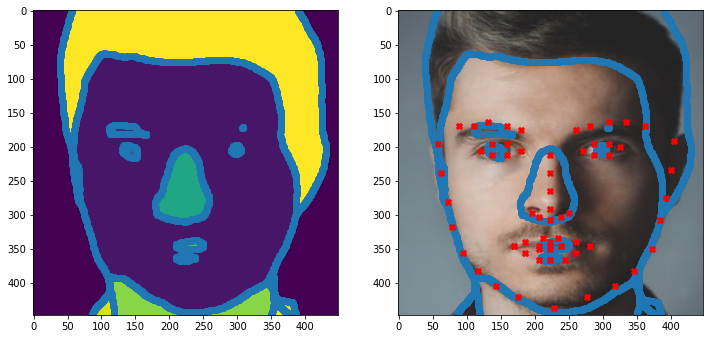

In [22]:
def test(network,path):
  fa = face_alignment.FaceAlignment(face_alignment.LandmarksType._2D, flip_input=False)
  
  timg = Image.open(path)
  timg = timg.resize((448, 448), Image.BILINEAR)
  timg = np.array(timg)
  img = timg
  timg = timg.transpose(2,0,1)
  timg = timg[np.newaxis,:,:,:]
  timg = torch.from_numpy(timg.astype(np.float)).type(torch.FloatTensor)
  timg = timg.to(device)
  pred = net(timg)
  pred = pred[0] + pred[1]+ pred[2]
  pred = pred[0]
  parsing = pred.squeeze(0).cpu().detach().numpy().argmax(0)

  FANpreds = fa.get_landmarks(img)
  FANpreds= np.array(FANpreds).reshape(68,2)

  x = np.linspace(0,447,448)
  y = np.linspace(0,447,448)
  # xx, yy = np.meshgrid(x, y)
  # zz = parsing
  cls = np.unique(parsing)
  points = []
  for i in cls:
    temp2 = np.zeros((448,448))
    x,y = np.where(parsing == i)
    temp2[x,y] = 255
    edges = cv2.Canny(np.uint8(temp2),448,448)
    x,y = np.where(edges == 255)
    for jj in range(len(x)):
      points.append([y[jj],x[jj],i])

  points = np.array(points)
  plt.figure(figsize=(12,12))
  plt.subplot(1,2,1)
  plt.imshow(parsing)
  plt.scatter(points[:,0],points[:,1])
  plt.subplot(1,2,2)
  plt.imshow(img)
  plt.scatter(points[:,0],points[:,1])
  plt.scatter(FANpreds[:,0],FANpreds[:,1],c='r',marker='X')


  return points

  # plt.figure(figsize=(12,8))
  # plt.imshow(parsing==1)
test(net,'imface.jpg')

# Validation part
This part will validate the network with 16 new picture which havnt been shown to the network and return the  average loss as metric for eval

In [15]:
score_thres = 0.7
n_min = n_img_per_gpu * cropsize[0] * cropsize[1]//16
LossP = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss2 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss3 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)



training_loss = []
loss_avg = []
st = glob_st = time.time()
diter = iter(dl)
diterTest = iter(dTest)
imTest,lbTest = next(diterTest)
imTest,lbTest = next(diterTest)
imTest,lbTest = next(diterTest)

epoch = 0

def Validation(net,optim,LossP,Loss2,Loss3,imTest,lbTest):

  with torch.no_grad():
    netT = net
    im = imTest.to(device)
    lb = lbTest.to(device)
    lb = torch.squeeze(lb, 1)
    print(im.size(),lb.size())
    out, out16, out32 = netT(im)
    outAll = out+ out16+ out32 
    print('done net')
    lossp = LossP(outAll, lb)
    loss = lossp
    # loss2 = Loss2(out16, lb)
    # loss3 = Loss3(out32, lb)
    # loss = lossp + loss2 + loss3
    print('done loss')
    loss_avg = []
    loss_avg.append(loss.item())
    loss_avg = sum(loss_avg) / len(loss_avg)
    del im,lb,netT
    print('Average validation Loss is',loss_avg)
    
  return loss_avg

Validation(net,optim,LossP,Loss2,Loss3,imTest,lbTest)

torch.Size([16, 3, 448, 448]) torch.Size([16, 448, 448])
done net
done loss
Average validation Loss is 2.4753870964050293


2.4753870964050293

This is the same but just for resnet with attention network

In [13]:
score_thres = 0.7
n_min = n_img_per_gpu * cropsize[0] * cropsize[1]//16
LossP = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss2 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss3 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)



training_loss = []
loss_avg = []
st = glob_st = time.time()
diter = iter(dl)
diterTest = iter(dTest)
imTest,lbTest = next(diterTest)
epoch = 0

def Validation(net,optim,LossP,Loss2,Loss3,imTest,lbTest):

  with torch.no_grad():
    netT = net
    im = imTest.to(device)
    lb = lbTest.to(device)
    lb = torch.squeeze(lb, 1)
    print(im.size(),lb.size())
    out, out16, out32 = netT(im)
    # outAll = out+ out16+ out32 
    print('done net')
    lossp = LossP(out, lb)
    loss2 = Loss2(out16, lb)
    loss3 = Loss3(out32, lb)
    loss = lossp + loss2 + loss3
    print('done loss')
    loss_avg = []
    loss_avg.append(loss.item())
    loss_avg = sum(loss_avg) / len(loss_avg)
    del im,lb,netT
    print('Average validation Loss is',loss_avg)
    
  return loss_avg

Validation(net,optim,LossP,Loss2,Loss3,imTest,lbTest)

torch.Size([16, 3, 448, 448]) torch.Size([16, 448, 448])
done net
done loss
Average validation Loss is 3.361849069595337


3.361849069595337

In [24]:
score_thres = 0.7
n_min = n_img_per_gpu * cropsize[0] * cropsize[1]//16
LossP = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss2 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)
Loss3 = OhemCELoss(thresh=score_thres, n_min=n_min, ignore_lb=ignore_idx)



training_loss = []
loss_avg = []
st = glob_st = time.time()
diter = iter(dl)
diterTest = iter(dTest)
imTest,lbTest = next(diterTest)
# imTest,lbTest = next(diterTest)
# imTest,lbTest = next(diterTest)

epoch = 0

def Validation(net,optim,LossP,Loss2,Loss3,imTest,lbTest):

  with torch.no_grad():
    netT = net
    im = imTest.to(device)
    lb = lbTest.to(device)
    lb = torch.squeeze(lb, 1)
    print(im.size(),lb.size())
    out, out16, out32 = netT(im)
    outAll = out+ out16+ out32 
    print('done net')
    lossp = LossP(outAll, lb)
    loss = lossp
    # loss2 = Loss2(out16, lb)
    # loss3 = Loss3(out32, lb)
    # loss = lossp + loss2 + loss3
    print('done loss')
    loss_avg = []
    loss_avg.append(loss.item())
    loss_avg = sum(loss_avg) / len(loss_avg)
    del im,lb,netT
    print('Average validation Loss is',loss_avg)
    
  return loss_avg

Validation(net,optim,LossP,Loss2,Loss3,imTest,lbTest)

torch.Size([16, 3, 448, 448]) torch.Size([16, 448, 448])
done net
done loss
Average validation Loss is 3.5423367023468018


3.5423367023468018